<center><img src="https://drive.google.com/uc?export=view&id=1apgBfsTFKlwZiLWXlGZT3qNljH2QPS3L" width=640 /></center>

<font size=6>
<center>Lesson 5: Computer Vision
</center>
</font>

<font size=4>
<center><i>Applying what we've learned to a new task</i>
</center>
</font>

# 1. Introduction

## Image Classification


In this lesson, we’ll switch to a new task: **image classification**. Image classification is essentially the same as text classification, just with images as input. We’ll be working with a dataset that contains pictures of outdoor scenes, while the task will be understanding what is shown in the picture. Take a look at some examples:

<center><img src="https://drive.google.com/uc?export=view&id=107CFSNUCb0NkXsjZcBmIDwwfAUf4KtaW" width=500 />

<i>This dataset is based on the [Kaggle Scene Classification dataset](https://www.kaggle.com/datasets/nitishabharathi/scene-classification)</i>

</center>



So, to put it in more formal terms we first encountered in lesson 1, for our task:

* The **objects** (inputs to the ML model) are images
* The **targets** (values we want to predict) are the classes (a number from 1-6, e.g. 1 - Building, 2 - Forest, and so on)

## Lesson Overview

We’ll try solving this image classification task using three different approaches:

1. **Training** a neural network for image classification from scratch
2. Fine-tuning a network trained for a different, but similar, task; this technique is called **transfer learning**
3. Using the **CLIP** text-and-image model in a **zero-shot learning** setup

Let’s note that this exercise was intentionally devised to be similar to the three ways of learning we saw in the previous lesson (training, fine-tuning, in-context learning), and we’ll explain this connection in more detail later!

<center><img src="https://drive.google.com/uc?export=view&id=13cyi2StlJ9EUXQURJ8ueWGw0JTEGr9Oz" width=400 /></center>

So, in this lesson, you’ll:

* Learn a **Vision Transformer** (ViT), and how to train it using HuggingFace
* Understand what **transfer learning** is and how to apply it to an image classification task
* Become familiar with the **CLIP** model and practice building classifiers with it in a **zero-shot** manner

<center><img src="https://drive.google.com/uc?export=view&id=1DX19aF36EPcDPQXnlNeGcQHQCPF1_NAi" width=1000 /></center>

# 2. Vision Transformer

## Loading and Exploring the Data

First, let's set up some of the general stuff that will be needed in the lesson:

In [ ]:
! pip install -qq transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have reques

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from PIL import Image
import os

import torch

# checking availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Next, let's download the dataset and extract it. Note that we’re using a smaller version of the dataset here to speed up the training:

In [ ]:
# library for downloading from google drive
! pip install gdown

# download this file by it's id:
# https://drive.google.com/file/d/1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA/view?usp=drive_link
! gdown --id 1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA -O scenes-tiny.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA
To: /content/scenes-tiny.zip
100% 9.53M/9.53M [00:00<00:00, 12.0MB/s]


In [ ]:
! unzip -qq scenes-tiny.zip

After running the code above, you should have a folder called "scenes-small" (if you are working in Google Colab, it will appear in your "Files" tab). This folder contains all the data in a format compatible with the HuggingFace dataset libraries. Let's take a look inside.

The dataset is split into three parts: train and test, which you are already familiar with; as well as val, which stands for **validation**. This third set, validation, is an additional layer between the training and test set, and is usually used to compute metrics during training and for choosing the epoch at which to stop training; this helps with avoiding overfitting on the test set.

Each of the sets have a separate directory with the following structure:

<br/>

```
scenes-small/train
        |-- Building/
        |---- 7262.jpg
        |---- 7267.jpg
        ...
        |-- Forest/
        |---- 6805.jpg
        |---- 6812.jpg
        ...
        |-- Street/
        |---- 6158.jpg
        |---- 6160.jpg
        ...
```

So, inside each main directory ("scenes-small/train", "scenes-small/val" or "scenes-small/test") there are 6 folders, each corresponding with one of the classes of scenes ("Building", "Forest", and so on). Each subdirectory contains pictures of the corresponding scenes.

We can now load the dataset using the `load_dataset` function from Hugging Face using `imagefolder` as dataset name:

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./scenes-tiny")

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
})

Let's take a look at an example image and its label:

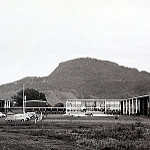

In [ ]:
# you can change num_image to view different images from data
num_image = 0
image = dataset['train'][num_image]['image']
image

In [ ]:
label = dataset['train'][num_image]['label']
label

0

We can also use the class names in the dataset, to make it more human readable:

In [ ]:
class_names = dataset['train'].features['label'].names
class_names

['Building', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']

In [ ]:
label = dataset['train'][num_image]['label']
class_names[label]

'Building'

Before you start training any model, it’s always a good idea to take a look at the data samples. With this in mind, here’s a function that displays a random set of images in a grid:

In [ ]:
def show_random_images(data):

    # create a grid
    f, axes_grid = plt.subplots(4, 4, figsize=(7, 7))

    # shuffling image indices
    image_indices = list(range(len(data)))
    np.random.shuffle(image_indices)

    i = 0
    for axes_row in axes_grid:
        for ax in axes_row:
            img = data[image_indices[i]]['image']
            label = data[image_indices[i]]['label']

            # display image
            ax.imshow(img)
            # set a label of an image as a title
            ax.set_title(class_names[label])
            # remove axis numerations for nicer view
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            i += 1

    # show resulting grid
    plt.show()

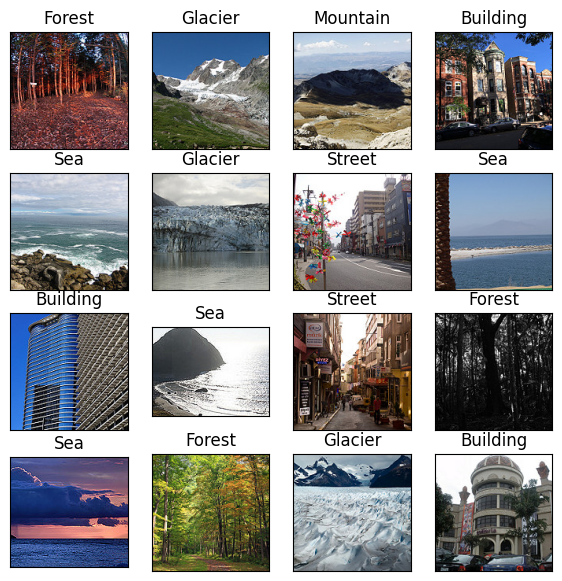

In [ ]:
show_random_images(dataset['train'])

Great! We’re ready to train a neural network model on our data.

## What is Vision Transformer?

For our first approach, we’ll train a **Vision Transformer (ViT)** model on our dataset for image classification from scratch.

Let's first take a moment to understand how ViT works. Basically, it does what its name implies and applies **Transformer** architecture to computer vision tasks:

1. The image is split into small **patches**, which are treated similarly to sequences of **tokens** with texts
2. Patches are **embedded** into vectors together with positional embeddings
3. The tokens are passed through a **transformer encoder** (multiple layers), just like the one we used in previous lessons for BERT and GPT
4. The final output embeddings go through additional **fully-connected feed-forward** layers (also known as multi-layered perceptron, or MLP, the oldest and most universal neuron network architecture), and a **softmax** function to generate class probabilities

<center><img src="https://drive.google.com/uc?export=view&id=1tEV7RnAJdlRD-DMW0nXrFaQ4DP1QHNTR" width=800 />

*Image from the original paper*
</center>

As a reminder: the main ingredient in the transformer architecture is the operation called **attention** (here, it's "multi-head attention", but the difference isn’t important). Attention works by matching together queries and keys produced from different tokens (with linear multiplications alone) and generating outputs based on how similar they are. Here’s an overview of this concept from lesson 3:

<center><img src="https://drive.google.com/uc?export=view&id=19F0BepzsGJRlHH0GiZMyfwk6LCFwR2c8" width=600 /></center>

<details>
    <summary><font color="404090">Why not convolutional architecture? (click to expand).</font></summary>
    
Maybe you've heard about **convolutional neural networks (CNN)**. These were very popular in computer vision before transformers and are still used in many applications. However, we opted not to use them for this lesson. First of all, this is because the details about how CNN architectures work are beyond the scope of this material. Additionally, we think our approach is worthwhile because, these days, transformers are becoming very competitive in the world of computer vision.
</details>

## Training the Model

We’ll use the ViT model from the transformers library. This will be similar to how we trained the BERT model in lesson 3, however we won’t be using auto-model to automatically configure the mode, so we’ll also need to create a config class for the model.

In [ ]:
from transformers import ViTConfig, ViTForImageClassification

In [ ]:
# using default configuration with a small update
configuration = ViTConfig()
configuration.num_labels = len(class_names)

# creating a ViT model with configuration
model = ViTForImageClassification(configuration).to(device)

When working with images, we also need to define the image transformations that we’ll use. Transformations usually include things like image resizing, value normalization, and so on. We won’t go too much into how to set all of this up, and instead, we’ll just use a default ViT image processor.

In [ ]:
from transformers import ViTImageProcessor

image_processor = ViTImageProcessor()


We also need to make a separate function for dataset transformation:

In [ ]:
def transform(dataset):

    """
    A function that takes a batch of data a of a format
    {
        'image': [list of images],
        'label': [list of labels]
    }
    and transforms all the images in it using image_processor.
    """

    # Transform images in dataset using image_processor
    transformed_dataset = image_processor(dataset['image'])

    # setting labels of newly transformed dataset with labels from initial dataset
    transformed_dataset['label'] = dataset['label']

    return transformed_dataset


transformed_dataset = dataset.with_transform(transform)

The final thing that we need to do before training is to define the function to compute metrics. In image classification, we can use exactly the same **accuracy** metric as before with text (the ratio of the correctly classified objects).

In [ ]:
from datasets import load_metric

def compute_metrics(eval_pred):
    accuracy = load_metric("accuracy", trust_remote_code=True)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": acc}

Now, before we start training the model, let’s review the training algorithm: **gradient descent**. This will help us better understand what’s going on during training.

The algorithm takes two hyperparameters: the number of steps as $N$ and learning rate $\alpha$, and works like this:



1. Choose a random starting value for the weight vector $w$

2. Repeat the following $N$ times:
    * Compute the loss function $L(w)$ and its gradient $\nabla L(w)$.

    * Update the weights by moving them into the direction of negative gradient, multiplying it by learning rate:

    $$
        w = w - \alpha \nabla L(w)
    $$


Recall that the **learning rate** hyperparameter controls how large the weight updates will be and it can have a lot of influence on training. If it’s too small, each step will be small and the overall training will be slow. On the other hand, if it is too big, the steps may overshoot into making the loss higher, and training may fail. The typical values for the learning rate are between $10^{-5}$ and $10^{-2}$.

**Exercise.** Your task is to train the model and achieve at least 50% accuracy. We've set up all the code for training and evaluation, but you need to find the correct training hyperparameters. Here, the most important ones are the learning rate and the number of epochs, however, if you wish, you may also play with other hyperparameters.

_Note: it should take no more than 10 minutes to train the model and get the desired accuracy._

<details>
    <summary><font color="404090">Hint (click to expand).</font></summary>
    
First, try increasing the number of epochs to be able to see how the accuracy changes over time. Then, play with the learning rate following the explanations above.
</details>

In [ ]:
# edit the code below code

from transformers import TrainingArguments, Trainer

# re-run the model creation for multiple experiments
model = ViTForImageClassification(configuration).to(device)

training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    evaluation_strategy="steps",
    logging_steps=10,
    eval_steps=10,
    remove_unused_columns=False, # utility argument for easier data processing

    learning_rate=0.05,
    num_train_epochs=5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)

train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)

metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,21.446600,15.254945,0.166667
20,9.587900,7.564033,0.166667


<ipython-input-17-280068b50a38>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy", trust_remote_code=True)


***** train metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.15
  eval_loss               =     2.3408
  eval_runtime            = 0:00:04.15
  eval_samples_per_second =      72.18
  eval_steps_per_second   =      9.143
***** test metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.1533
  eval_loss               =     2.3373
  eval_runtime            = 0:00:02.43
  eval_samples_per_second =     61.485
  eval_steps_per_second   =      7.788


In [ ]:
# <SOLUTION>

from transformers import TrainingArguments, Trainer

# re-run the model creation for multiple experiments
model = ViTForImageClassification(configuration).to(device)

training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    evaluation_strategy="steps",
    logging_steps=10,
    eval_steps=10,
    remove_unused_columns=False, # utility argument for easier data processing

    learning_rate=1e-4,
    num_train_epochs=20,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)


train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)

metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,2.143100,1.662919,0.340000
20,1.419600,1.457785,0.406667
30,1.303600,1.366594,0.486667
40,1.183400,1.292364,0.460000
50,1.032000,1.155003,0.553333
60,0.912200,1.093271,0.533333
70,0.779600,1.114103,0.546667
80,0.653000,1.106835,0.566667
90,0.530500,1.133843,0.573333
100,0.453800,1.092884,0.593333


***** train metrics *****
  epoch                   =       20.0
  eval_accuracy           =       0.86
  eval_loss               =      0.431
  eval_runtime            = 0:00:04.87
  eval_samples_per_second =      61.55
  eval_steps_per_second   =      7.796
***** test metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.5867
  eval_loss               =     1.2375
  eval_runtime            = 0:00:02.88
  eval_samples_per_second =     51.986
  eval_steps_per_second   =      6.585


We didn’t get the best results, and the network has already started to **overfit** (reminder: this means that the quality on the training set is better than the quality on the testing set). This is mainly due to the low amount of data for this rather complex task. In the next section, we’ll learn how to use another approach called transfer learning which will help us get a better performing model in less time and effort.

**Bonus task.** You can try to play with this model and see how high you can push its quality.


<details>
    <summary><font color="404090">Some ideas on what you can do (click to expand).</font></summary>


1. Change the number of layers or attention heads in the model by adjusting the `num_attention_heads` and `num_hidden_layers` parameters in the model configurations. You can use common sense here: if your model is easily overfitting, try to make the model smaller; if your model is underfitting, try to make the model bigger.
2. Adjust the size of the input images. If your model is easily overfitting, it's a good idea to try smaller image sizes (via the `image size` parameter in the configuration).
3. Add **data augmentation** to the training dataset. This is a powerful technique that adds randomized data transformations to make it look like the dataset is much larger. Here are some guides on data augmentation:
    - [What is image augmentation?](https://albumentations.ai/docs/introduction/image_augmentation/)
    - [PyTorch documentation on augmentation](https://pytorch.org/vision/main/transforms.html)
    - [ Augmentation techniques in PyTorch illustrated](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
    - In order to add augmentation to our model, you'll need to add augmenting transformations to our "transform" function. You can find an example of how to do that [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb)

</details>

# 3. Transfer Learning

## Why do we need transfer learning?

The big problem for many machine learning tasks is that there is **never enough data**. Consider these tasks:



1. **Medical image classification**. As an example, take tumor detection in MRI images. This is a much harder task than just  understanding a scene (e.g. distinguishing mountains from forests). Further MRI images can be taken in a lot of ways, and tumors come in all shapes and sizes. At the same time, the amount of data is very small, because labeling each sample takes a lot of work and involves highly qualified professionals.
2. **Machine translation for rare languages**. In order to train the model for direct translation, we need pairs of sentences in one language with its analogous translation in the second language. This is a difficult task by itself, even for languages with lots of translation examples, like English and French. If we want to train the model for some less common language, such as from Vietnamese to English, the amount of data shrinks considerably. Pairing two non-common languages makes the problem even more difficult!

In general, almost any task can benefit from more data, so that's why transfer learning is such a useful tool! Now that we know why it’s useful, let’s try to understand how it works.

<center><img src="https://drive.google.com/uc?export=view&id=1lckfEYwblZQpEZEw1CS6l-2z_5itYHZU" width=400 /></center>

## Fine-tuning as Transfer Learning

Transfer learning is where we train a model on one dataset, then transfer the knowledge to another, related dataset. The simplest way to do this consists of two steps:



1. **Pre-training** a general model on a big dataset that is only vaguely related to our specific task
2. **Fine-tuning** this model on a smaller dataset for our specific task

We've already talked about this approach a little bit in previous lessons, now we want to go deeper.

Let's discuss how transfer learning works in practice by looking at our task of scene classification.

First, we need a dataset for **pre-training**, and it needs to be large and slightly relevant to our task. One possible option is to collect a large photo dataset composed of any kind of objects from online, no matter the context, then train a model to classify them (spoiler: a dataset like this does exist). The model wouldn't be able to predict what we want with a high level of precision, but at least it will be able to learn the basics about how the images are structured.

Next, we take this model and **fine-tune** it on our smaller dataset, in a manner designed to specifically understand scenes from a small set of classes. This is the same model training, but starting with the weights acquired on the previous step, and with a much smaller amount of epochs.


<center><img src="https://drive.google.com/uc?export=view&id=1Q-2iVC26O2AwsWrrI1mnkar0H1OfHaCB" width=1000 /></center>

To try to develop some intuition for how this fine-tuning technique works, consider the following: let's suppose you want to learn to drive a motorcycle. Compared to starting from scratch, it would be easier to learn if you already know how to drive a car because you already know how traffic regulations work, have some basic intuition about driving vehicles, and know how to understand and analyze what’s happening on the road. This is fundamental knowledge which you gain by driving any kind of vehicle (**pre-training**), so then, when switching from one vehicle to another, you only need to learn the residual aspects (**fine-tuning**). So, in the end, you'll require fewer lessons ("less data") to properly learn what you need to know.

It’s obvious that, the **closer the two datasets** are (for pre-training and for fine-tuning), the better transfer learning will work. For example, if you know Spanish, it would be easier for you to learn Portuguese than Chinese. That said, in practice, transfer learning works well even for quite **different datasets**! This happens because low-level data details (e.g. images have contours that convey important information) are still quite universal, and make up a big portion of the difficulty for any task.

Also, note that even if you have a fair amount of data for your task, it can still be a good idea to apply the transfer learning approach. As we said earlier, there is rarely enough data in the world of machine learning!

## Transfer Learning for ViT

Now, let's see how transfer learning for images works in our scene understanding task. We need a **big, general-task dataset** for pretraining – and luckily there is one we can easily use!

That dataset is called **ImageNet**, and it is made up of images collected from the Internet, each labeled with information about what is being displayed. This dataset is very popular in computer vision because of its size and generality. We’ll be using a larger version of this dataset called Imagenet-21k; it has 14 million images and 21 thousand classes.

<center><img src="https://drive.google.com/uc?export=view&id=1xP5LNXf8lgQWhjB1uH4qpsQ22CMwZEbz" width=600 /></center>

Obviously, we’re not going to be training an image classification model from scratch on our own — that would take a lot of computational resources, and the whole point of this section is to avoid that. Fortunately, HuggingFace already has an ViT model trained on ImageNet that we can use, so let's load it.

In [ ]:
from transformers import ViTForImageClassification

model_name = 'google/vit-base-patch16-224-in21k'

# we need to pass an amount of classes in our dataset to
# ViTForImageClassification so that our model is build
# for the specified number of classes
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We need to re-define the image transformations that will be applied for the images in our dataset. Here's one important thing to keep in mind: it’s better to use the same image transformations that were used to pre-train the model on ImageNet. This is simply because, during pre-training, our model "got used to" images being transformed in a certain way. In other words, it became well-suited for images with certain characteristics, so it's better to transform images in the same way during fine-tuning, too.

In [ ]:
from transformers import ViTFeatureExtractor

# loading image processor with the same model name
image_processor = ViTFeatureExtractor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
def transform(dataset):
    '''
    A function that takes a batch of data a of a format
    {
        'image': [list of images],
        'label': [list of labels]
    }
    and transforms all the images in it using image_processor
    '''

    transformed_dataset = image_processor(dataset['image'])
    transformed_dataset['label'] = dataset['label']
    return transformed_dataset


transformed_dataset = dataset.with_transform(transform)

**Exercise.** Now fine-tune the model! Your goal now is much higher: try to get at least 90% accuracy. Additionally, try to achieve this accuracy in 5 epochs or less. As before, all the code is below, but you need to set the correct training hyperparameters.

<details>
    <summary><font color="404090">Hint (click to expand).</font></summary>
    
This time you need to increase the learning rate – but not too much.
</details>

**Bonus exercise.** Try to get 90% accuracy in just 2 epochs!


<details>
    <summary><font color="404090">Hint (click to expand).</font></summary>
    
Decreasing the size of the batch may help.
</details>

In [ ]:
# edit the code below code



from transformers import TrainingArguments, Trainer


model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names))

training_args = TrainingArguments(
    output_dir="./logs",
    evaluation_strategy="steps",
    remove_unused_columns=False,

    # more frequent steps for more information
    logging_steps=5,
    eval_steps=5,

    per_device_train_batch_size=64,
    learning_rate=1e-6,
    num_train_epochs=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    # datasets for training and validating
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)


train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)
metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
5,1.791700,1.790452,0.140000
10,1.787200,1.786899,0.140000
15,1.779800,1.783736,0.160000
20,1.775600,1.781036,0.180000
25,1.774900,1.778759,0.186667
30,1.770100,1.776898,0.186667
35,1.767600,1.775443,0.193333
40,1.766300,1.774401,0.193333
45,1.764800,1.773758,0.206667
50,1.763700,1.773515,0.206667


***** train metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.25
  eval_loss               =     1.7637
  eval_runtime            = 0:00:04.42
  eval_samples_per_second =     67.726
  eval_steps_per_second   =      8.579
***** test metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.1733
  eval_loss               =     1.7807
  eval_runtime            = 0:00:02.78
  eval_samples_per_second =     53.778
  eval_steps_per_second   =      6.812


In [ ]:
# <SOLUTION>

from transformers import TrainingArguments, Trainer


model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names))

training_args = TrainingArguments(
    output_dir="./logs",
    evaluation_strategy="steps",
    remove_unused_columns=False,

    # more frequent steps for more information
    logging_steps=5,
    eval_steps=5,

    per_device_train_batch_size=32,
    learning_rate=5e-4,
    num_train_epochs=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    # datasets for training and validating
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)


train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)
metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
5,1.438600,0.895304,0.853333
10,0.723400,0.644508,0.826667
15,0.442200,0.473834,0.893333
20,0.303200,0.420282,0.893333


***** train metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9967
  eval_loss               =     0.2602
  eval_runtime            = 0:00:04.39
  eval_samples_per_second =     68.203
  eval_steps_per_second   =      8.639
***** test metrics *****
  epoch                   =        2.0
  eval_accuracy           =       0.92
  eval_loss               =     0.4185
  eval_runtime            = 0:00:02.65
  eval_samples_per_second =     56.466
  eval_steps_per_second   =      7.152


<details>
    <summary><font color="404090">Exercise conclusions (click to expand).</font></summary>

Great! We got much better results with less training time (not counting a probably enormous pre-training time).
</details>


Fine-tuning a model usually takes less iterations over data, so it’s usually less prone to overfitting. However, this can still happen!

There is a trick that can help prevent this, while at the same time speeding up training even more: **layer freezing**. This is when we only train a part of the network’s layers, while all other layers are kept fixed (i.e. "frozen"). In transfer learning, it usually makes sense to freeze everything except a couple of the last layers. The reasoning behind this is that the first layers of the network learn more low-level details, which are relevant for all kinds of various tasks (exactly what we want from pre-training). Meanwhile, the last layer corresponds with more high-level, abstract concepts, which we want to update for the new dataset (the goal of the fine-tuning).

<center><img src="https://drive.google.com/uc?export=view&id=1gbLcXPplvrzp2uToQLTpKC8hFR4Vj53K" width=1000 /></center>

Depending on how different the datasets are for pre-training and fine-tuning, we may want to freeze different amounts of layers: for example, we can freeze only 2 or 3 initial layers if the datasets are very different, or almost the entire network if they are very close.

We won't be doing any layer freezing in this lesson, but if you want, you can try it yourself. Here’s a [thread](https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386) on the Hugging Face forums that may help!

To conclude this section, it’s also worth mentioning that transfer learning is not only limited to classification tasks. For example, models pre-trained on ImageNet can be adapted for image segmentation, detection, and so on.

# 4. Classification Using CLIP

In this section, we'll use a pre-trained model called CLIP for our classification task. But CLIP isn’t a model for image classification, and we have something different in mind about how to use it. Before we jump in, let’s talk about what CLIP is.

## Understanding CLIP

Remember how BERT created text embeddings and ViT created image embeddings (before classification, that is)? Well, CLIP is able to create both in a common embedding space! The idea is that, if a text $T$ is a good description of an image $I$, their embeddings are close to each other, while embeddings of images and random non-related texts are far from each other.

CLIP consists of two neural networks:

* An **image encoder**, which maps an image into a vector
* A **text encoder**, which maps text into a vector of the same length

These two networks are trained together on a dataset of paired images and their descriptions $(I_1, T_1), \ldots, (I_N, T_N)$. They use an unusual loss function, called **contrastive loss**. We won't go into much detail about this, but basically, it creates a table of embeddings for each pair of image  $I_j$ and text $T_k$, and then:

- if $i=j$, then the loss is **distance** between them (thus forcing them to be close to each other)
- if $i \neq j$, then the loss is **negative distance** between them (thus forcing them to be far from each other)

<center><img src="https://drive.google.com/uc?export=view&id=1wYwJa2sp4rfscvPd4ZZdf1ETOMipM-_S" width=800 />

*Image from the original paper*

</center>

As a result, after this training, we get two models (text encoder and image encoder), which map related text and images into similar embeddings, and unrelated text and images into dissimilar embeddings.

## Zero-Shot Prediction with CLIP

Now, let's talk about how to use CLIP for image classification without any further training. This is called **zero-shot** prediction because we are not training the model in any way.

It's simple: suppose we have an image classification task with 4 classes of images: "plane", "car", "dog", "bird". How can we understand for a given image $I$ which of the four classes this image belongs to?



Let's do the following:

- Get embedding $e_I$ of $I$ using the image encoder
- Convert class names $X$ into class descriptions with the form "a photo/picture/image of a X":

    "a photo of a plane"

    "a photo of a car"

    "a photo of a dog"

    "a photo of a bird"

- Get embeddings $e_{plane}, e_{car}, e_{dog}, e_{bird}$ of all of the class descriptions
- Compute similarities between image embedding $e_I$ and the embeddings of the class descriptions:

    $sim_{I, plane} = e_I \cdot e_{plane}$

    $sim_{I, car} = e_I \cdot e_{car}$

    $sim_{I, dog} = e_I \cdot e_{dog}$

    $sim_{I, bird} = e_I \cdot e_{bird}$

    …and then choose the class which has the highest similarity (e.g. if $sim_{I, car}$ has the highest value across all four, then we conclude that our image belongs to the "car" class.)




So, here,we’re directly utilizing the idea that a text related to the image content will have a CLIP embedding similar to CLIP image embedding. If our image is an image of a car, its CLIP embedding will be close to the CLIP embedding of a phrase "a photo of a car", and far from CLIP embeddings of other phrases.

<center>
<img src="https://drive.google.com/uc?export=view&id=1rO-f7-LW4myvkn4W0tNwtEx91vkxNm0j" width=600 />

*Image from the original paper*
</center>

Note that, as we said before, we don't need to perform any model training, we’re just using it in **zero-shot** mode! CLIP was trained with a contrastive loss objective for  general similarity understanding, and we’re now adapting this to the image classification task; this approach is very similar to the **in-context** learning that we've done in the previous lesson with prompt engineering for ChatGPT.

## Image Classification

Let’s do what we’ve discussed for real with our scenes dataset. Yet again, the trained CLIP model already exists in the `transformers` library in HuggingFace.

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# this is the original model by OpenAI
model_name = "openai/clip-vit-base-patch32"


model = CLIPModel.from_pretrained(model_name).to(device)
# This is for pre-processing text and images before passing to CLIP model
processor = CLIPProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Let’s next see how to pass images and texts to the model: first, we’ll take two random images from the dataset.

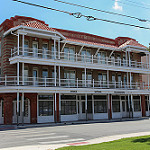

In [ ]:
dataset['test'][0]['image']

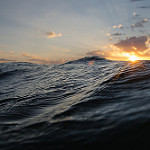

In [ ]:
dataset['test'][101]['image']

In [ ]:
images = [dataset['test'][0]['image'], dataset['test'][101]['image']]

Do you remember how CLIP can work with arbitrary texts also? Let's create some examples.

In [ ]:
texts = [
    "some houses or whatever",   # this should be somewhat similar to the first image
    "sea with waves",    # this should be somewhat similar to the second image
    "transformer is a type of neural network architecture"   # this should not be similar to anything
]

Now, let's pass texts and images through the model; they’ll need to be passed through simultaneously to generate their similarity matrix.

In [ ]:
# prepare texts and images for the model
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

# pass the dictionary as keywords
outputs = model(**inputs)

This `outputs` variable contains lots of information that we don't need (you can try to print it and see). The similarity matrix that we need is saved in the property `logits_per_image`:

In [ ]:
outputs.logits_per_image

tensor([[20.8680, 19.3224, 18.9444],
        [16.8145, 26.1218, 19.9856]], device='cuda:0', grad_fn=<TBackward0>)

The numbers above don't have any specific meaning, the only thing that matters is how they compare to each other. There are 2 rows (for each image) and 3 columns (for each text), and each cell is the similarity between the corresponding image and text. As we can see, this similarity corresponds to what we expected: the first text is close to the first image, second to the second, the third text is not close to anything.

With that, let's move on to our image classification task.

**Exercise.** Create a function `clip_predict()` that takes an image as input and returns its prediction of the class label. Use the code example above for passing images and texts through the model. You’ll also need to create a set of appropriate prompts with class descriptions to compare them with images.

<details>
    <summary><font color="404090">Hint (click to expand).</font></summary>

Here’s how to make prompts: for each class name, you need to create a text for the class with this format: "A picture of ...".
</details>




In [36]:
# your code here

# extract the classes from
class_names = dataset['test'].features['label'].names

# create a prompt for each class
prompts = ...

def clip_predict(image):
    # pass all the prompts and the image to the processor
    inputs = ...

    # pass the inputs to the model
    outputs = ...

    # get the prompt with the highest value
    prediction = ...

    return prediction

In [37]:
# <SOLUTION>

class_names = dataset['test'].features['label'].names
prompts = ['A picture of {}'.format(class_name) for class_name in class_names]

def clip_predict(image):
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits_per_image, dim=1)
    return prediction

In [38]:
# get class index and print its name
prediction = clip_predict(dataset['test'][0]['image'])
print(dataset['test'].features['label'].names[prediction])

Building



Next up, let's test this function on our dataset!

**Exercise.** Using the function `clip_predict()` from the previous exercise, write the function `evaluate_clip()` for computing the classification accuracy with CLIP.

In [ ]:
# your code here

def evaluate_clip(dataset):
    ...


evaluate_clip(dataset['test'])

In [ ]:
# <SOLUTION>

def evaluate_clip(dataset):
    num_correct = 0

    for image_data in tqdm(dataset):
        prediction = clip_predict(image_data['image'])
        label = image_data['label']

        num_correct += prediction.cpu() == label

    accuracy = num_correct / len(dataset)

    return accuracy.numpy()

evaluate_clip(dataset['test'])

  0%|          | 0/150 [00:00<?, ?it/s]

array([0.9066667], dtype=float32)

Voila! The CLIP model in **zero-shot** mode performs quite well: we end up with around 90% accuracy without any actual training on our data! This is even better than how ChatGPT performed on the Yelp reviews task from the previous lesson, (however, the scene classification task is probably simpler).


# 6. Conclusion

That’s the end of our lesson on image classification, so let’s wrap up what we've learned:

* We trained and tested the **Vision Transformer** network from scratch on our data
* We learned about concept of **Transfer Learning** and **fine-tuned** a ViT model using HuggingFace library
* We learned about **contrastive learning** and used a pre-trained **CLIP model** to solve an image classification task in **zero-shot** mode

Here are some additional materials for further reading:



* A [guide](https://viso.ai/deep-learning/vision-transformer-vit/) on Vision Transformers and [another guide](https://www.v7labs.com/blog/vision-transformer-guide) on ViT.
* A [guide](https://www.v7labs.com/blog/transfer-learning-guide) on Transfer Learning.
* A [blogpost](https://lilianweng.github.io/posts/2021-05-31-contrastive/) explaining Contrastive Loss.

There are many other things you can do with CLIP, here are some resources that can help:



* The [CLIP release page](https://openai.com/research/clip)<span style="text-decoration:underline;">.</span>
* An [overview](https://medium.com/nightcafe-creator/vqgan-clip-tutorial-a411402cf3ad) of an approach for image generating using CLIP, and [in this colab notebook](https://colab.research.google.com/drive/1wkF67ThUz37T2_oPIuSwuO4e_-0vjaLs?usp=sharing) you can generate images using CLIP yourself.
* [Here you can find more tasks](https://blog.roboflow.com/openai-clip/) that CLIP can help solve.